<IPython.core.display.Javascript object>


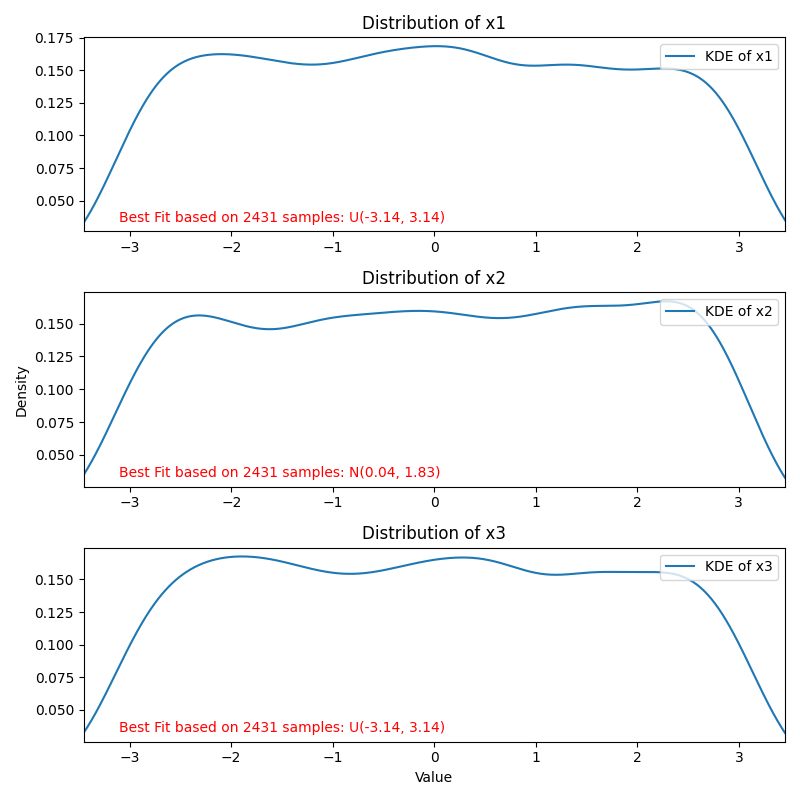

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde, norm, uniform

# Database configurations
DB_CONFIG = {
    'user': 'root',
    'password': 'password',
    'host': '127.0.0.1',
    'database': 'mydb'
}

# Ensure interactive plots
%matplotlib notebook

def get_data():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()
    cursor.execute("SELECT x1, x2, x3 FROM my_table")
    data = cursor.fetchall()
    cursor.close()
    cnx.close()
    return np.array(data)

def fit_distributions(data_col):
    # Fit to normal distribution
    mu, std = norm.fit(data_col)
    norm_sse = np.sum((data_col - norm.pdf(data_col, mu, std))**2)
    
    # Fit to uniform distribution
    min_val, max_val = np.min(data_col), np.max(data_col)
    uniform_sse = np.sum((data_col - uniform.pdf(data_col, min_val, max_val - min_val))**2)
    
    # Return the distribution with the lowest SSE
    if norm_sse < uniform_sse:
        return f"N({mu:.2f}, {std:.2f})"
    else:
        return f"U({min_val:.2f}, {max_val:.2f})"

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
labels = ["x1", "x2", "x3"]

def update(frame):
    data = get_data()
    
    for ax, col, label in zip(axs, data.T, labels):
        ax.clear()

        # Determine the data range for proper plotting
        data_min = np.min(col) - 0.1 * np.abs(np.min(col))
        data_max = np.max(col) + 0.1 * np.abs(np.max(col))

        # Generate evaluation points based on the data's range
        x_eval = np.linspace(data_min, data_max, 1000)

        # KDE for the data
        kde = gaussian_kde(col)

        # Plotting
        ax.plot(x_eval, kde(x_eval), label=f"KDE of {label}")
        ax.set_title(f"Distribution of {label}")
        ax.set_xlim(data_min, data_max)
        ax.legend(loc='upper right')

        
        # Get best-fit distribution and display it on the plot
        best_fit_distribution = fit_distributions(col)
        n_samples = len(col)
        ax.annotate(f"Best Fit based on {n_samples} samples: {best_fit_distribution}", xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10, color="red")
    axs[2].set_xlabel("Value")
    axs[1].set_ylabel("Density")
    plt.tight_layout()

ani = FuncAnimation(fig, update, interval=1000)
plt.show()

<IPython.core.display.Javascript object>


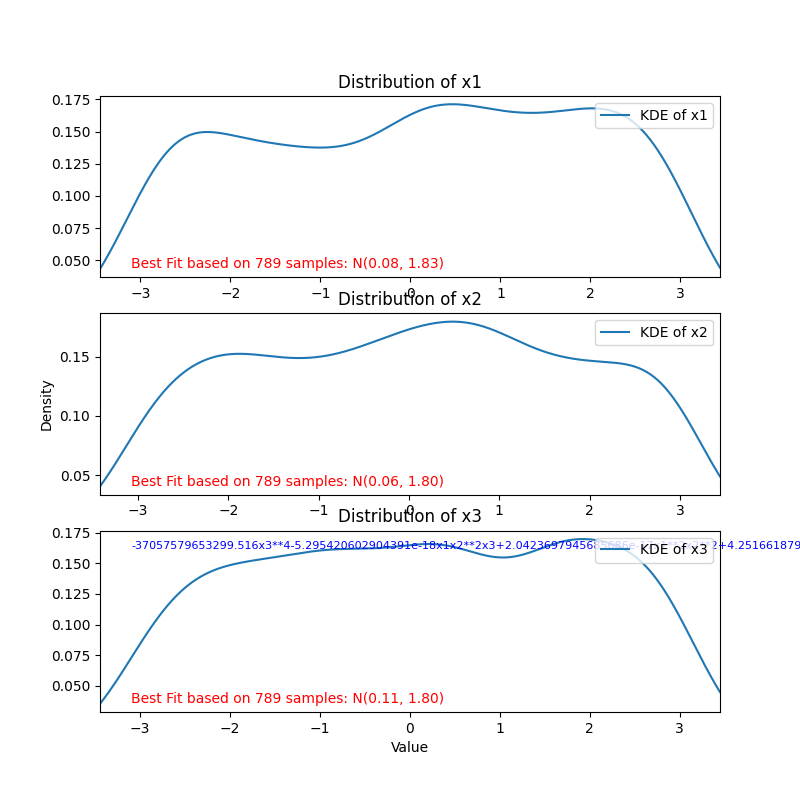

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
import chaospy as cp
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde, norm, uniform

# Database configurations
DB_CONFIG = {
    'user': 'root',
    'password': 'password',
    'host': '127.0.0.1',
    'database': 'mydb'
}

# Ensure interactive plots
%matplotlib notebook

def get_data():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()
    cursor.execute("SELECT x1, x2, x3 FROM my_table")
    data = cursor.fetchall()
    cursor.close()
    cnx.close()
    return np.array(data)

def ishigami(x):
    x1, x2, x3 = x
    a = 7
    b = 0.1
    return np.sin(x1) + a * np.sin(x2)**2 + b * x3**4 * np.sin(x1)

def fit_distributions(data_col):
    mu, std = norm.fit(data_col)
    norm_sse = np.sum((data_col - norm.pdf(data_col, mu, std))**2)
    
    min_val, max_val = np.min(data_col), np.max(data_col)
    uniform_sse = np.sum((data_col - uniform.pdf(data_col, min_val, max_val - min_val))**2)
    
    if norm_sse < uniform_sse:
        return cp.Normal(mu, std), f"N({mu:.2f}, {std:.2f})"
    else:
        return cp.Uniform(min_val, max_val), f"U({min_val:.2f}, {max_val:.2f})"

def compute_pce_approximation(func, distributions, N=4, K=3):
    distribution = cp.J(*distributions)
    poly = cp.expansion.stieltjes(N, distribution, normed=True)
    nodes, weights = cp.generate_quadrature(K, distribution, rule="G")
    evaluations = np.apply_along_axis(func, 1, nodes.T)
    pc_approx, _ = cp.fit_quadrature(poly, nodes, weights, evaluations, retall=True)
    return pc_approx, nodes

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
labels = ["x1", "x2", "x3"]

def update(frame):
    data = get_data()
    
    for ax, col, label in zip(axs, data.T, labels):
        ax.clear()
        data_min = np.min(col) - 0.1 * np.abs(np.min(col))
        data_max = np.max(col) + 0.1 * np.abs(np.max(col))
        x_eval = np.linspace(data_min, data_max, 1000)
        kde = gaussian_kde(col)
        ax.plot(x_eval, kde(x_eval), label=f"KDE of {label}")
        ax.set_title(f"Distribution of {label}")
        ax.set_xlim(data_min, data_max)
        ax.legend(loc='upper right')

        best_fit_distribution = fit_distributions(col)
        n_samples = len(col)
        ax.annotate(f"Best Fit based on {n_samples} samples: {best_fit_distribution[1]}", xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10, color="red")

    distributions = [fit_distributions(col)[0] for col in data.T]
    pc_approx, _ = compute_pce_approximation(ishigami, distributions)
    
    polynomial_str = str(pc_approx).replace("*q0", "x1").replace("*q1", "x2").replace("*q2", "x3")
    axs[2].annotate(polynomial_str, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=8, color="blue")
    
    axs[2].set_xlabel("Value")
    axs[1].set_ylabel("Density")
    plt.tight_layout()

ani = FuncAnimation(fig, update, interval=1000)
plt.show()
